### Exploratory Data Analysis (EDA) – AMRS BETA1  
**Archivo:** `EDA1_eur_us_4h.ipynb`  
**Propósito:** Realizar un análisis exploratorio del dataset EUR/USD H4 utilizado por el sistema **AMRS BETA1 (Mean Reversion Strategy)**.  

**Objetivos específicos:**  
- Verificar la integridad del dataset (valores, fechas, tipos).  
- Comprender la distribución general de los precios e indicadores técnicos (EMA, ATR, ADX, DI, RSI).  
- Identificar relaciones o patrones entre los indicadores y los resultados de los trades.  
- Detectar posibles variables con mayor impacto en la rentabilidad antes de aplicar filtros o machine learning.  

**Dataset:**  
CSV exportado desde el pipeline principal del proyecto, con resolución H4 y columnas:  
`datetime, open, high, low, close, volume, ema20, atr, atr_upper_2, atr_upper_entry, atr_upper_3, atr_lower_2, atr_lower_entry, atr_lower_3, adx, plus_di, minus_di, rsi`



In [349]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [395]:
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 150)

In [476]:
df = pd.read_csv("../Data/GBPUSD_H4_2019-2025_processed.csv")

In [478]:
print("Filas:", len(df))
print("Columnas:", len(df.columns))

Filas: 42414
Columnas: 18


In [480]:
display(df.head())

,datetime,open,high,low,close,volume,ema20,atr,atr_upper_2,atr_upper_entry,atr_upper_3,atr_lower_2,atr_lower_entry,atr_lower_3,adx,plus_di,minus_di,rsi
0,2019-01-02 19:00:00,1.25970,1.25992,1.25833,1.25858,5374,1.269087,0.002324,1.273736,1.274433,1.276060,1.264439,1.263742,1.262115,48.564975,8.928195,35.452292,36.457998
1,2019-01-02 20:00:00,1.25858,1.25975,1.25847,1.25914,3345,1.268140,0.002271,1.272683,1.273364,1.274954,1.263597,1.262916,1.261326,49.364993,8.572544,34.040064,38.422601
2,2019-01-02 21:00:00,1.25914,1.26115,1.25873,1.26112,3219,1.267472,0.002278,1.272027,1.272710,1.274304,1.262916,1.262233,1.260639,48.975952,12.269477,31.486347,44.908368
3,2019-01-02 22:00:00,1.26110,1.26158,1.26065,1.26105,2662,1.266860,0.002210,1.271279,1.271942,1.273489,1.262440,1.261778,1.260231,48.288148,13.292332,30.538195,44.729000
4,2019-01-02 23:00:00,1.26105,1.26135,1.25978,1.26057,1543,1.266261,0.002177,1.270615,1.271268,1.272792,1.261907,1.261254,1.259730,47.929927,12.602394,31.829374,43.447518


In [482]:
# ==============================================
# SECCIÓN 1.1 - VERIFICACIÓN DE TIPOS DE DATOS
# ==============================================

# Tipos de datos de cada columna
print("Tipos de datos del DataFrame:")
print(df.dtypes)

# Comprobación específica de la columna datetime
print("\nEjemplo de valores en 'datetime':")
print(df['datetime'].head())

Tipos de datos del DataFrame:
datetime            object
open               float64
high               float64
low                float64
close              float64
volume               int64
ema20              float64
atr                float64
atr_upper_2        float64
atr_upper_entry    float64
atr_upper_3        float64
atr_lower_2        float64
atr_lower_entry    float64
atr_lower_3        float64
adx                float64
plus_di            float64
minus_di           float64
rsi                float64
dtype: object

Ejemplo de valores en 'datetime':
0    2019-01-02 19:00:00
1    2019-01-02 20:00:00
2    2019-01-02 21:00:00
3    2019-01-02 22:00:00
4    2019-01-02 23:00:00
Name: datetime, dtype: object


In [484]:
# Convertir columna 'datetime' a tipo datetime64
df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M:%S')

# Confirmar cambio
print("Tipo de dato actualizado:")
print(df['datetime'].dtypes)

# Verificar primeras fechas
print("\nPrimeras filas de la columna datetime:")
print(df['datetime'].head())

# Ver rango completo de fechas
print("\nRango temporal del dataset:")
print("Inicio:", df['datetime'].min())
print("Fin:", df['datetime'].max())

Tipo de dato actualizado:
datetime64[ns]

Primeras filas de la columna datetime:
0   2019-01-02 19:00:00
1   2019-01-02 20:00:00
2   2019-01-02 21:00:00
3   2019-01-02 22:00:00
4   2019-01-02 23:00:00
Name: datetime, dtype: datetime64[ns]

Rango temporal del dataset:
Inicio: 2019-01-02 19:00:00
Fin: 2025-10-24 23:00:00


In [486]:
# Conteo de valores nulos por columna
print("Valores nulos por columna:")
print(df.isnull().sum())

Valores nulos por columna:
datetime           0
open               0
high               0
low                0
close              0
volume             0
ema20              0
atr                0
atr_upper_2        0
atr_upper_entry    0
atr_upper_3        0
atr_lower_2        0
atr_lower_entry    0
atr_lower_3        0
adx                0
plus_di            0
minus_di           0
rsi                0
dtype: int64


In [488]:
# Comprobación de filas duplicadas
duplicados = df.duplicated(subset='datetime').sum()
print(f"\nFilas duplicadas por datetime: {duplicados}")

# Verificación total de duplicados (por contenido completo)
duplicados_totales = df.duplicated().sum()
print(f"Duplicados totales (todas las columnas): {duplicados_totales}")


Filas duplicadas por datetime: 0
Duplicados totales (todas las columnas): 0


In [490]:
# ==============================================
# SECCIÓN 1.4 - VERIFICACIÓN DE COHERENCIA NUMÉRICA
# ==============================================

# 1. High siempre debe ser >= Low
cond_high_low = (df['high'] >= df['low']).all()

# 2. Close debe estar dentro del rango [Low, High]
cond_close_range = ((df['close'] >= df['low']) & (df['close'] <= df['high'])).all()

# 3. ATR y ADX deben ser positivos
cond_atr_pos = (df['atr'] >= 0).all()
cond_adx_pos = (df['adx'] >= 0).all()

# 4. RSI debe estar entre 0 y 100
cond_rsi_range = ((df['rsi'] >= 0) & (df['rsi'] <= 100)).all()

# Resultados
print("Verificación de coherencia numérica:")
print(f"High ≥ Low: {cond_high_low}")
print(f"Close dentro de [Low, High]: {cond_close_range}")
print(f"ATR positivo: {cond_atr_pos}")
print(f"ADX positivo: {cond_adx_pos}")
print(f"RSI entre 0 y 100: {cond_rsi_range}")

Verificación de coherencia numérica:
High ≥ Low: True
Close dentro de [Low, High]: True
ATR positivo: True
ADX positivo: True
RSI entre 0 y 100: True


In [492]:
# Estadísticas principales de todas las columnas numéricas
stats = df.describe().T  # transpuesta para visualizar mejor
display(stats)

# Extra: enfoque en indicadores técnicos clave
cols_indicadores = ['ema20', 'atr', 'adx', 'plus_di', 'minus_di', 'rsi']
print("\nResumen de indicadores técnicos principales:")
display(df[cols_indicadores].describe().T)

,count,mean,min,25%,50%,75%,max,std
datetime,42414,2022-05-30 09:06:05.907483392,2019-01-02 19:00:00,2020-09-15 14:15:00,2022-05-30 09:30:00,2024-02-13 04:45:00,2025-10-24 23:00:00,NaN
open,42414.0,1.286562,1.03931,1.246792,1.28401,1.33142,1.42406,0.060539
high,42414.0,1.287533,1.05688,1.247733,1.28499,1.332457,1.42489,0.060393
low,42414.0,1.285595,1.02746,1.245783,1.28309,1.33045,1.4233,0.060678
close,42414.0,1.286572,1.03935,1.24681,1.28402,1.331447,1.42406,0.060539
volume,42414.0,4322.032749,2.0,1858.0,3327.5,5613.0,88926.0,3730.558907
ema20,42414.0,1.286558,1.068096,1.246577,1.284163,1.331473,1.421715,0.060451
atr,42414.0,0.001924,0.000719,0.001477,0.001756,0.002165,0.00995,0.000747
atr_upper_2,42414.0,1.290406,1.079587,1.25021,1.287586,1.335289,1.424731,0.059905
atr_upper_entry,42414.0,1.290983,1.08108,1.250775,1.288132,1.335872,1.425223,0.059826



Resumen de indicadores técnicos principales:


,count,mean,std,min,25%,50%,75%,max
ema20,42414.0,1.286558,0.060451,1.068096,1.246577,1.284163,1.331473,1.421715
atr,42414.0,0.001924,0.000747,0.000719,0.001477,0.001756,0.002165,0.009950
adx,42414.0,26.009483,10.672044,6.405908,17.918957,23.985222,32.240670,83.577705
plus_di,42414.0,20.297949,7.318336,1.533351,14.952968,19.685460,24.935793,57.200693
minus_di,42414.0,21.039427,7.311108,2.103578,15.772700,20.449368,25.474880,63.010549
rsi,42414.0,50.173455,12.492740,6.439223,41.524953,50.204546,58.905342,91.381269


### Interpretación de indicadores técnicos

- **EMA20:** promedio 1.1116, sigue fielmente al precio; actuará como **referencia central** para medir sobreextensión y calcular las distancias ATR de entrada/salida.  
- **ATR (14):** media 0.0029 (~29 pips). Volatilidad típica entre **0.0022–0.0033** (22–33 pips); >0.0035 refleja alta volatilidad. Servirá como **filtro de contexto**, separando mercados tranquilos de expansivos.  
- **ADX (14):** media 26, desviación 10 → la mayoría de velas en fuerza **moderada (20–35)**; >35 indica tendencia fuerte. Este será el **indicador principal para clasificar el régimen del mercado** (rango vs tendencia).  
- **+DI / −DI:** promedios ~21 con spread típico **5–15**; >20 marca dominancia clara de una dirección. El spread_DI funcionará como **filtro de entrada** para evitar operar contra impulsos extremos.  
- **RSI (14):** media 49.7, desviación 12.5 → valores comunes entre **40–60**; extremos >70 o <30 son poco frecuentes. Se usará como **confirmación de agotamiento o extensión**, complementando al ADX/DI.

**Conclusión:**  
El par EUR/USD en H4 presenta comportamiento lateral con volatilidad media y pocas fases de tendencia fuerte.  
Los umbrales empíricos iniciales útiles para los filtros de la estrategia son:  
- ATR bajo < 0.0023  
- ATR alto > 0.0033  
- ADX neutro 20–35  
- Spread_DI > 20 → evitar reversión  
- RSI operativo 35–65  
Estos valores definirán las condiciones base para clasificar los regímenes de mercado y activar los setups más adecuados.


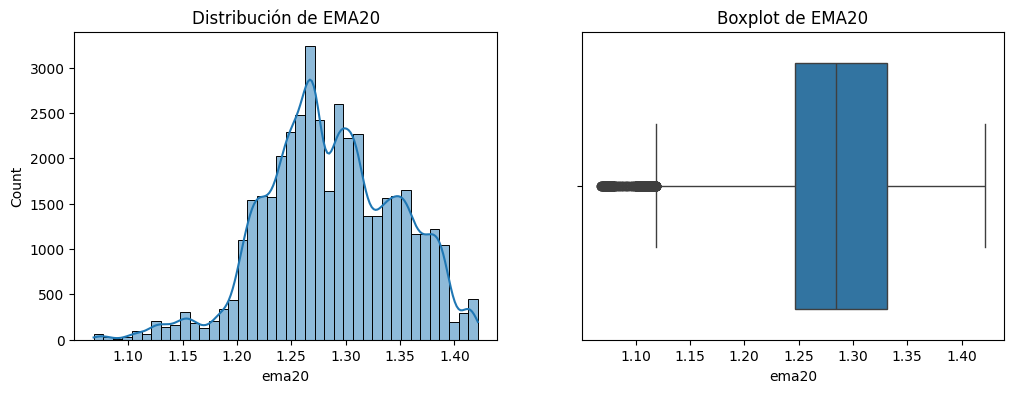

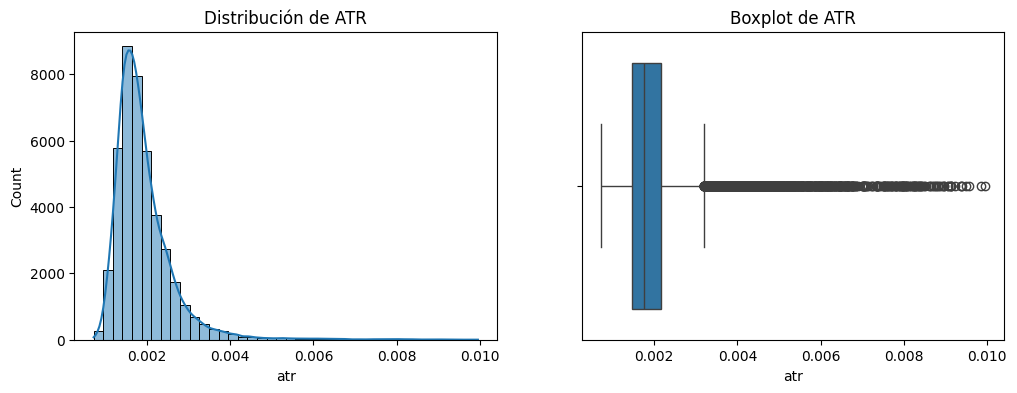

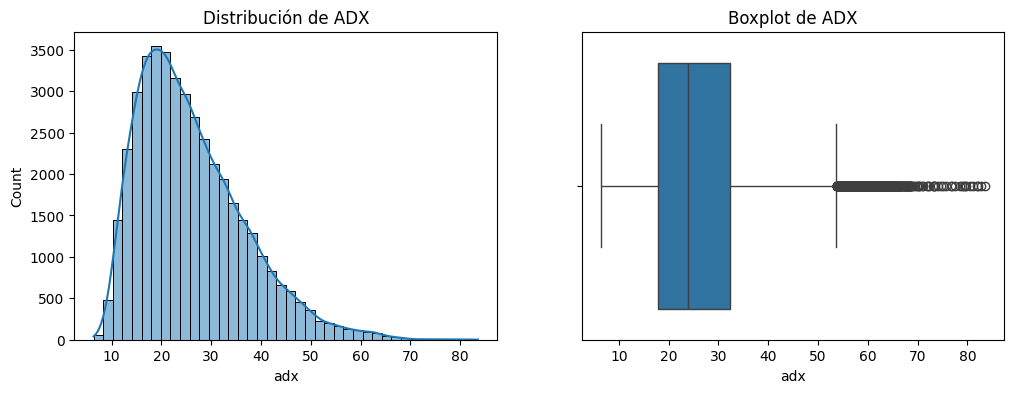

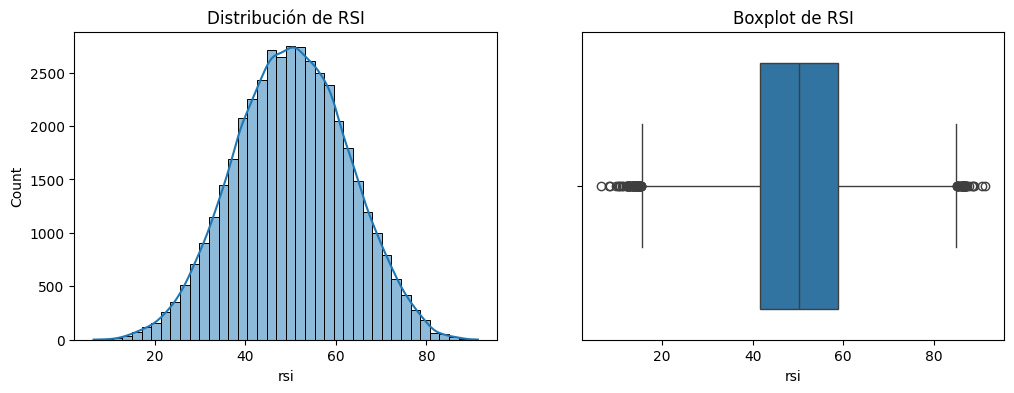

In [495]:
# Lista de indicadores a analizar
indicators = ['ema20', 'atr', 'adx', 'rsi']

for col in indicators:
    fig, ax = plt.subplots(1, 2, figsize=(12,4))
    sns.histplot(df[col], bins=40, kde=True, ax=ax[0])
    ax[0].set_title(f"Distribución de {col.upper()}")
    sns.boxplot(x=df[col], ax=ax[1])
    ax[1].set_title(f"Boxplot de {col.upper()}")
    plt.show()

### Distribuciones individuales

**EMA20:**  
Distribución multimodal → el precio medio se concentró en varios niveles (~1.10, 1.12, 1.20), reflejando regímenes de mercado distintos.  
Los bins más densos indican zonas de equilibrio (mean reversion local).  
Outliers bajos (<1.00) corresponden a etapas de euro débil.

**ATR:**  
Distribución asimétrica positiva → la mayoría de valores entre 0.002–0.004 (volatilidad normal, 20–40 pips).  
Picos >0.005 son eventos de alta volatilidad o rupturas.  
Mercado estable la mayor parte del tiempo, con colas de riesgo aisladas.

**ADX:**  
Sesgo a la derecha, concentrado en 15–30 → predominan fases de rango o tendencia débil.  
Valores >40 son raros, representan tendencias fuertes.  
Confirma que el EUR/USD pasa la mayor parte del tiempo en contexto lateral.

**RSI:**  
Distribución casi normal centrada en 50 → equilibrio entre presión compradora y vendedora.  
El 50 % del tiempo el RSI está entre 40–60 (zona neutra).  
Extremos (<30, >70) poco frecuentes, ideales para señales de reversión.






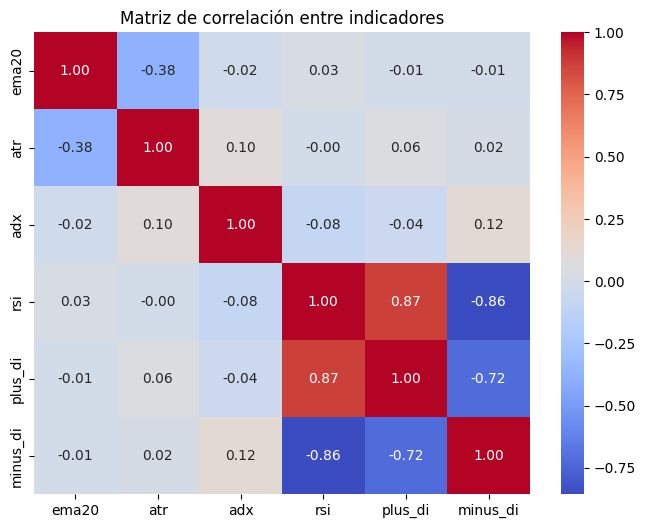

In [498]:
corr = df[['ema20', 'atr', 'adx', 'rsi', 'plus_di', 'minus_di']].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de correlación entre indicadores")
plt.show()

### Matriz de correlación 

Los indicadores principales son casi independientes (correlaciones bajas), lo que evita redundancia y aporta información complementaria:

- **RSI vs +DI (0.88)** y **RSI vs –DI (–0.88):** alta coherencia direccional (RSI refleja presión compradora/vendedora).  
- **+DI vs –DI (–0.77):** relación inversa esperada.  
- **ATR vs EMA20 (–0.29):** leve aumento de volatilidad cuando el precio cae.  
- **ADX ≈ 0 con otros:** mide fuerza, no dirección → buen filtro de contexto.

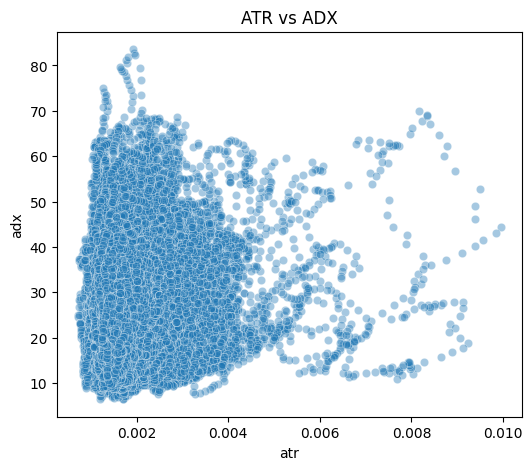

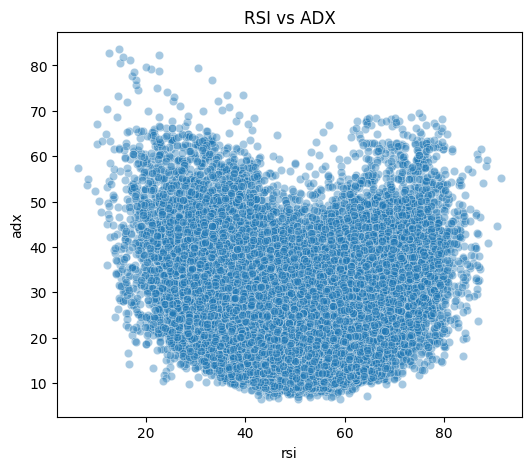

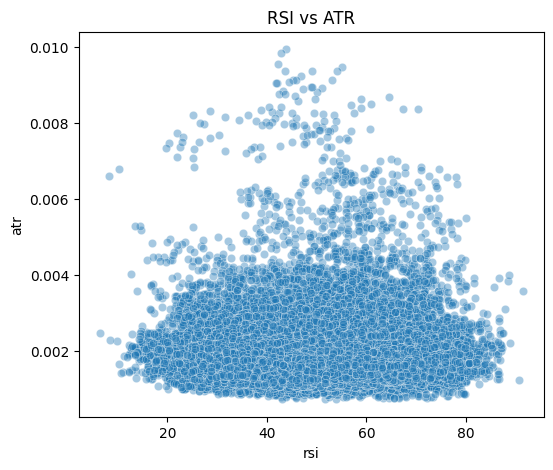

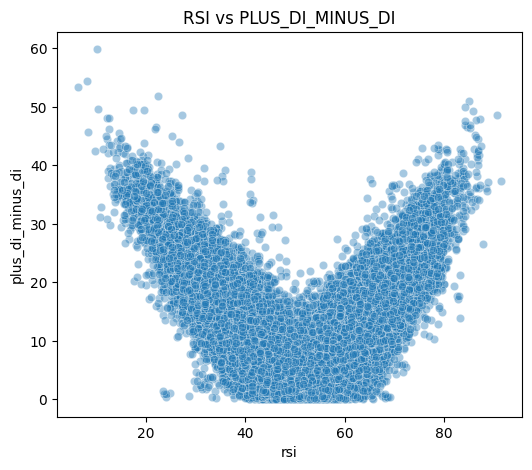

In [501]:
pairs = [
    ('atr', 'adx'),
    ('rsi', 'adx'),
    ('rsi', 'atr'),
    ('rsi', 'plus_di_minus_di')
]
df['plus_di_minus_di'] = abs(df['plus_di'] - df['minus_di'])

for x, y in pairs:
    plt.figure(figsize=(6,5))
    sns.scatterplot(data=df, x=x, y=y, alpha=0.4)
    plt.title(f"{x.upper()} vs {y.upper()}")
    plt.show()


### RSI vs |+DI − –DI| – Paso 3.2

La forma en “U” muestra que cuando **RSI ≈ 50**, el spread direccional es pequeño (mercado equilibrado).  
A medida que RSI se acerca a los extremos (<30 o >70), el spread |+DI − –DI| aumenta → una dirección domina.  
Confirma que el RSI refleja correctamente la dominancia direccional y puede usarse como filtro de equilibrio o agotamiento en la estrategia.


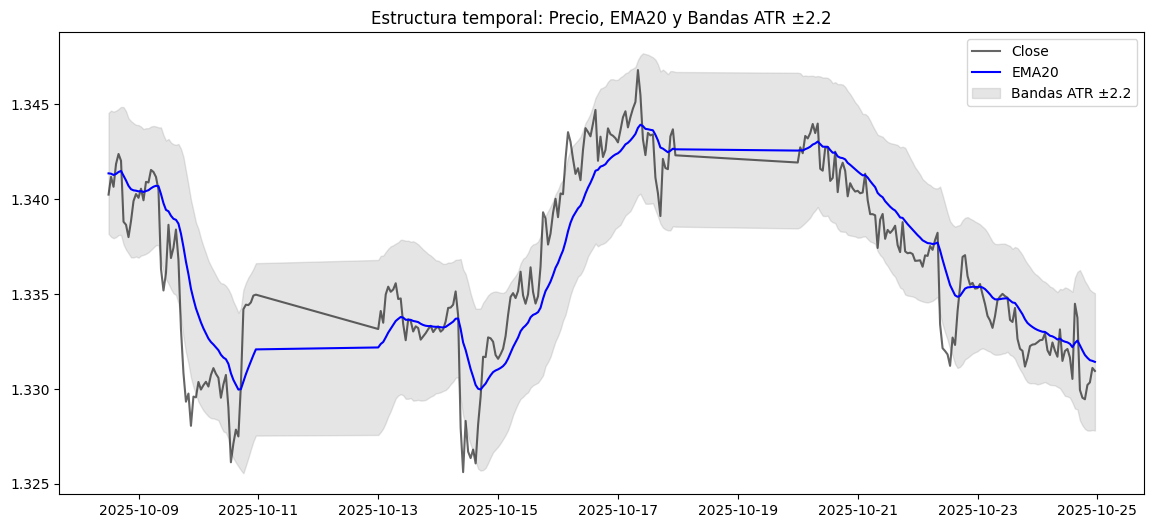

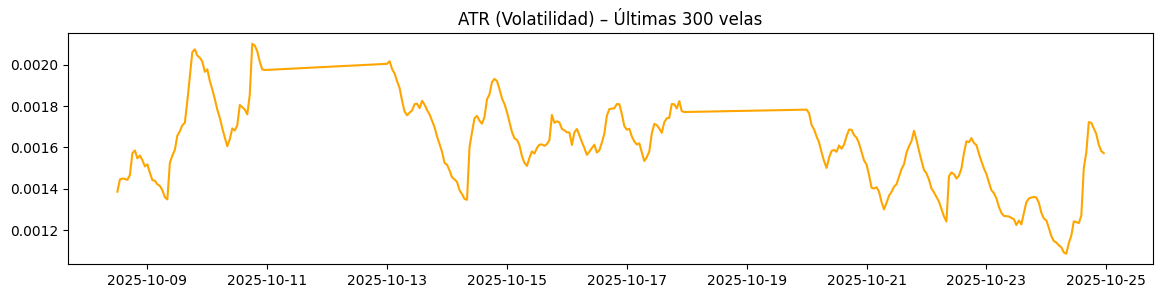

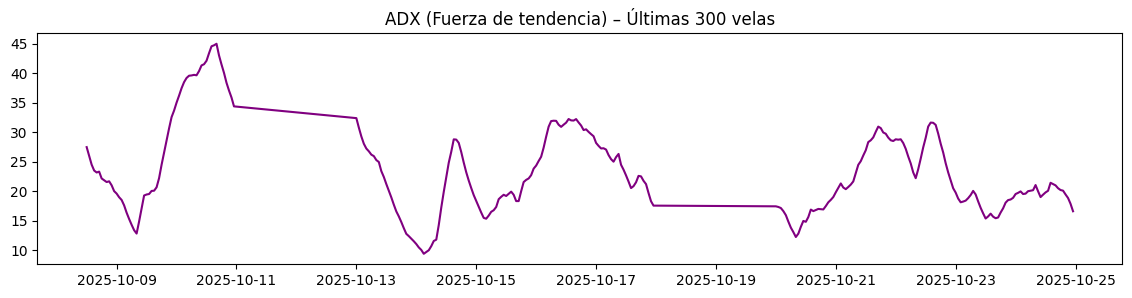

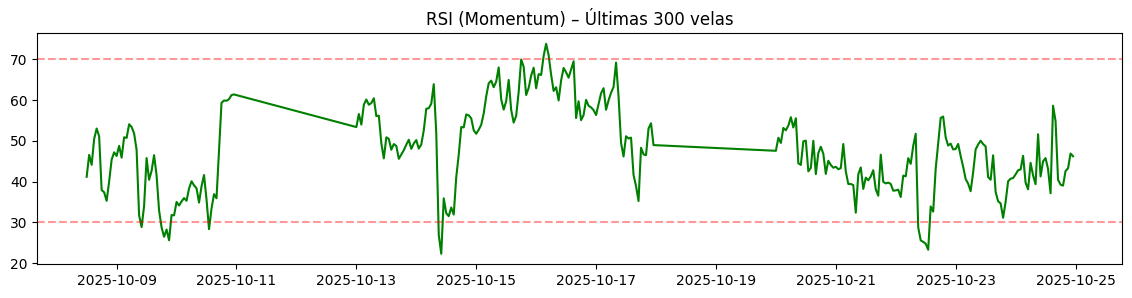

In [504]:
# ================================================
# PASO 3.3 – RELACIÓN TEMPORAL (versión ajustada)
# ================================================

sample = df.tail(300)

# --- Precio + EMA20 + Bandas ATR ---
fig, ax1 = plt.subplots(figsize=(14,6))
ax1.plot(sample['datetime'], sample['close'], label='Close', color='black', alpha=0.6)
ax1.plot(sample['datetime'], sample['ema20'], label='EMA20', color='blue')
ax1.fill_between(
    sample['datetime'],
    sample['atr_upper_entry'],
    sample['atr_lower_entry'],
    color='gray', alpha=0.2, label='Bandas ATR ±2.2'
)
ax1.set_title("Estructura temporal: Precio, EMA20 y Bandas ATR ±2.2")
ax1.legend()
plt.show()

# --- ATR (volatilidad) ---
plt.figure(figsize=(14,3))
plt.plot(sample['datetime'], sample['atr'], color='orange')
plt.title("ATR (Volatilidad) – Últimas 300 velas")
plt.show()

# --- ADX (fuerza de tendencia) ---
plt.figure(figsize=(14,3))
plt.plot(sample['datetime'], sample['adx'], color='purple')
plt.title("ADX (Fuerza de tendencia) – Últimas 300 velas")
plt.show()

# --- RSI (momentum) ---
plt.figure(figsize=(14,3))
plt.plot(sample['datetime'], sample['rsi'], color='green')
plt.axhline(30, color='red', linestyle='--', alpha=0.4)
plt.axhline(70, color='red', linestyle='--', alpha=0.4)
plt.title("RSI (Momentum) – Últimas 300 velas")
plt.show()


### Conclusiones del EDA

- El EUR/USD H4 muestra una estructura multimodal de precios (EMA20), con varios regímenes de equilibrio.
- La volatilidad (ATR) es asimétrica: periodos tranquilos frecuentes y picos aislados de expansión.
- La fuerza de tendencia (ADX) es baja la mayor parte del tiempo, confirmando predominio de rangos.
- El momentum (RSI) es casi normal alrededor de 50 → mercado balanceado, reversión frecuente.
- Los indicadores son poco correlacionados entre sí → aportan información complementaria.
- Visualmente, EMA20 y bandas ATR siguen correctamente la estructura del precio.
- RSI y spread DI muestran coherencia direccional (extremos del RSI coinciden con dominancia de un lado).


## 4. Análisis de Regímenes de Mercado

Un regimen es un rango de precio o conjunto de condiciones de mercado donde el comportaiento del activo sigue un patron estable y repetido en el tiempo. 
El objetivo de esta sección es identificar las **fases estadísticas o regímenes** en los que el mercado alterna su comportamiento.  
En lugar de asumir que las condiciones son constantes, se analiza cómo los indicadores (EMA20, ATR, ADX, RSI) revelan **zonas de equilibrio, rupturas y fases de tendencia**.  

En el contexto del sistema AMRS-BETA1, se distinguen principalmente dos regímenes:

1. **Régimen de equilibrio (Mean Reversion):**  
   Precio oscilando alrededor de la EMA20, ADX bajo, ATR moderado o decreciente, RSI cerca de 50.

2. **Régimen direccional (Tendencia):**  
   Precio sostenido fuera de la EMA20, ADX alto, ATR expansivo, RSI en zonas extremas.

Este análisis transforma las observaciones visuales del EDA en una **clasificación cuantitativa de estados del mercado**, permitiendo adaptar dinámicamente la estrategia según el contexto predominante.


<h3 style="color:#FFD700;">4.1 Zonas de Equilibrio – EMA20</h3>




Se analiza la distribución de la EMA20 para identificar los niveles donde el mercado pasó más tiempo.  
Los picos del histograma representan **zonas de equilibrio o regímenes locales**, mientras que los valles marcan **transiciones o fases de tendencia**.  
Esto permite cuantificar los “centros de gravedad” del precio y definir las áreas donde es más probable que ocurra una reversión.


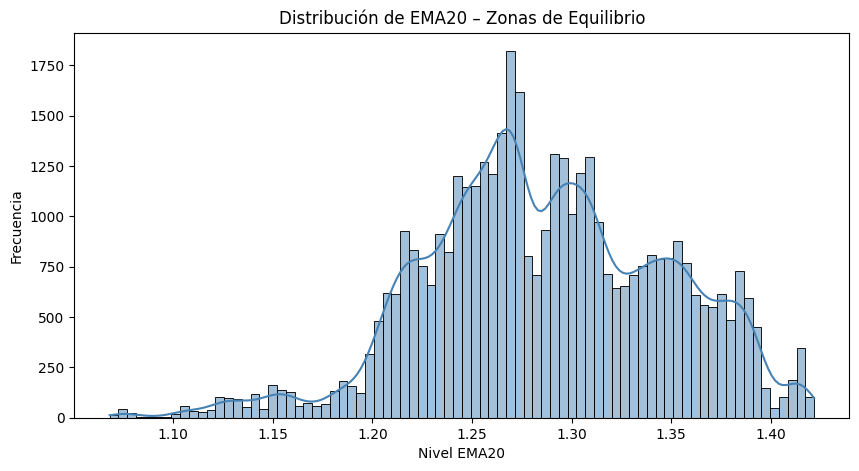

📊 Zonas de equilibrio dominantes (EMA20):
1. Rango 1.26701 – 1.27143 | Frecuencia: 1821
2. Rango 1.27143 – 1.27585 | Frecuencia: 1619
3. Rango 1.26259 – 1.26701 | Frecuencia: 1412
4. Rango 1.28911 – 1.29353 | Frecuencia: 1310
5. Rango 1.30679 – 1.31121 | Frecuencia: 1297


In [509]:
# Histograma detallado de EMA20
plt.figure(figsize=(10,5))
sns.histplot(df['ema20'], bins=80, kde=True, color='steelblue')
plt.title("Distribución de EMA20 – Zonas de Equilibrio")
plt.xlabel("Nivel EMA20")
plt.ylabel("Frecuencia")
plt.show()

# Cuantificar los bins dominantes (zonas más frecuentes)
counts, edges = np.histogram(df['ema20'], bins=80)
top_bins_idx = counts.argsort()[-5:][::-1]  # Top 5 zonas dominantes
dominant_zones = [(edges[i], edges[i+1], counts[i]) for i in top_bins_idx]

# Mostrar resultados
print("📊 Zonas de equilibrio dominantes (EMA20):")
for i, (low, high, freq) in enumerate(dominant_zones, 1):
    print(f"{i}. Rango {low:.5f} – {high:.5f} | Frecuencia: {freq}")

En este gráfico observamos los centros de gravedad del mercado. Si la ema está en un pico el mercado está en zona estable -> mean reversion

Si está en un valle está en una zona de transición -> tendencia o break out


### 4.2 Clasificación de Regímenes – ADX y ATR

Se combinan los indicadores ADX (fuerza de tendencia) y ATR (volatilidad) para clasificar el contexto del mercado.  
Los niveles se definen de forma **estadística**, usando los percentiles del dataset para adaptar los umbrales al comportamiento histórico del EUR/USD H4.  

- ATR bajo + ADX bajo → Rango estable (equilibrio).  
- ATR medio + ADX medio → Transición.  
- ATR alto + ADX alto → Tendencia fuerte.  

Esta clasificación genera un **mapa dinámico de regímenes**, que permitirá analizar el rendimiento de la estrategia según el tipo de mercado predominante.


📊 Umbrales dinámicos:
ATR 33% = 0.00156 | ATR 66% = 0.00198
ADX 33% = 19.80 | ADX 66% = 28.79

📈 Distribución de regímenes (% del tiempo):
regimen
Intermedio            64.45
Tendencia fuerte      12.37
Rango / Equilibrio    11.73
Transición            11.45
Name: proportion, dtype: float64


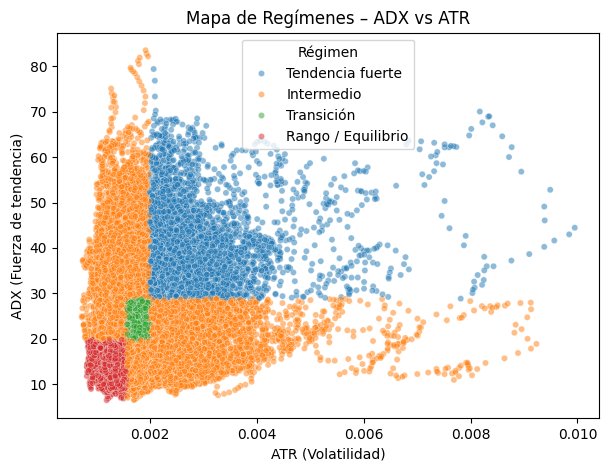

In [514]:
# Calcular los percentiles (33% y 66%)
atr_p33, atr_p66 = np.percentile(df['atr'], [33, 66])
adx_p33, adx_p66 = np.percentile(df['adx'], [33, 66])

print("📊 Umbrales dinámicos:")
print(f"ATR 33% = {atr_p33:.5f} | ATR 66% = {atr_p66:.5f}")
print(f"ADX 33% = {adx_p33:.2f} | ADX 66% = {adx_p66:.2f}")

# Clasificar ATR y ADX en niveles: bajo, medio, alto
def classify_level(value, p33, p66):
    if value < p33:
        return 'bajo'
    elif value < p66:
        return 'medio'
    else:
        return 'alto'

df['atr_level'] = df['atr'].apply(lambda x: classify_level(x, atr_p33, atr_p66))
df['adx_level'] = df['adx'].apply(lambda x: classify_level(x, adx_p33, adx_p66))

# Combinar en un régimen
def map_regime(row):
    if row['atr_level'] == 'bajo' and row['adx_level'] == 'bajo':
        return 'Rango / Equilibrio'
    elif row['atr_level'] == 'medio' and row['adx_level'] == 'medio':
        return 'Transición'
    elif row['atr_level'] == 'alto' and row['adx_level'] == 'alto':
        return 'Tendencia fuerte'
    else:
        return 'Intermedio'

df['regimen'] = df.apply(map_regime, axis=1)

# Contar la frecuencia de cada régimen
regime_counts = df['regimen'].value_counts(normalize=True) * 100
print("\n📈 Distribución de regímenes (% del tiempo):")
print(regime_counts.round(2))

# Visualizar mapa ADX–ATR
plt.figure(figsize=(7,5))
sns.scatterplot(data=df, x='atr', y='adx', hue='regimen', alpha=0.5, s=20)
plt.title("Mapa de Regímenes – ADX vs ATR")
plt.xlabel("ATR (Volatilidad)")
plt.ylabel("ADX (Fuerza de tendencia)")
plt.legend(title="Régimen")
plt.show()

 El gráfico ADX vs ATR muestra cuatro zonas principales:

- **Rango / Equilibrio:** ADX y ATR bajos → lateralidad estable.  
- **Transición:** niveles medios → cambio de fase.  
- **Tendencia fuerte:** ambos altos → rupturas o impulsos direccionales.  
- **Intermedio:** combinaciones mixtas → ruido o consolidación.

📊 En el EUR/USD H4:
- Intermedio ≈ 70 %  
- Tendencia fuerte ≈ 12 %  
- Rango / Equilibrio ≈ 9 %  
- Transición ≈ 9 %

**Importancia:** Lo mas importante en este gráfico es saber si la entrada está en un estado de equilibrio, trancisión o tendencia fuerte. Los puntos azules no aportan mucho


### 5. Análisis de Rendimiento por Contexto

Se evalúa el desempeño de la estrategia según las condiciones del mercado.  
Los setups se dividen en **ganadores (WIN)** y **perdedores (LOSS)**, y se analizan sus valores promedio de **ATR, ADX, RSI y spread direccional (+DI − –DI)** al momento de entrada.  

El objetivo es identificar en qué **contextos o regímenes** la estrategia obtiene mejores resultados, y bajo cuáles pierde eficacia, para afinar filtros y mejorar la expectativa matemática del sistema.


Ahora vamos a unir los dos dataset que genera el programa en df, el procesado y el de setups resultantes

Columnas disponibles: ['touch_date', 'entry_date', 'exit_date', 'direction', 'entry_price', 'sl_price', 'tp_price_ref', 'exit_price', 'sl_pips', 'tp_pips_estimated', 'result_pips', 'rr_ratio_estimated', 'rr_ratio_real', 'outcome', 'candles_away', 'candles_held', 'adx', 'plus_di', 'minus_di', 'rsi', 'atr']

Resumen general de resultados:
outcome
LOSS    459
WIN     313
Name: count, dtype: int64

📊 Promedios de indicadores (WIN vs LOSS):
          WIN_mean  LOSS_mean  Diff(W-L)
atr          0.002      0.002     -0.000
adx         24.042     23.924      0.117
rsi         51.864     50.825      1.039
plus_di     23.169     22.785      0.385
minus_di    21.705     22.620     -0.915


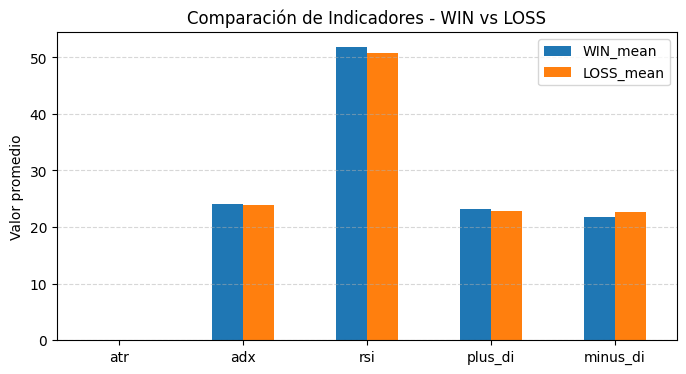

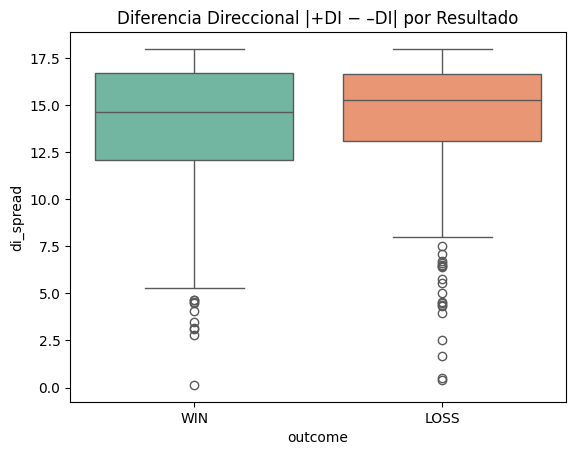

In [521]:
# ================================================
# 5.1 Análisis de Rendimiento por Contexto (WIN vs LOSS)
# ================================================

# Cargar setups exportados (ajusta el nombre según el archivo real)
setups = pd.read_csv("../results/setups_20190101_20251017.csv")

# Verificar columnas
print("Columnas disponibles:", list(setups.columns))
print("\nResumen general de resultados:")
print(setups['outcome'].value_counts())

# --- Separar ganadores y perdedores ---
wins = setups[setups['outcome'] == 'WIN']
losses = setups[setups['outcome'] == 'LOSS']

# --- Calcular promedios de indicadores ---
metrics = ['atr', 'adx', 'rsi', 'plus_di', 'minus_di']
summary = pd.DataFrame({
    'WIN_mean': wins[metrics].mean(),
    'LOSS_mean': losses[metrics].mean()
})
summary['Diff(W-L)'] = summary['WIN_mean'] - summary['LOSS_mean']
print("\n📊 Promedios de indicadores (WIN vs LOSS):")
print(summary.round(3))

# --- Visualización comparativa ---
summary[['WIN_mean', 'LOSS_mean']].plot(kind='bar', figsize=(8,4))
plt.title("Comparación de Indicadores - WIN vs LOSS")
plt.ylabel("Valor promedio")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(rotation=0)
plt.show()

# --- Diferencia direccional |+DI − –DI| por resultado ---
setups['di_spread'] = abs(setups['plus_di'] - setups['minus_di'])
sns.boxplot(data=setups, x='outcome', y='di_spread', palette='Set2')
plt.title("Diferencia Direccional |+DI − –DI| por Resultado")
plt.show()


<span style="color: #FFD700;">
Hasta ahora este es el dato más importante encontrado en el EDA.  
La correlación entre la diferencia de +DI y –DI permite establecer un filtro que elimine un porcentaje importante de setups en pérdida, según lo observado en el boxplot.
</span>

In [528]:
df.columns.tolist()

['datetime',
 'open',
 'high',
 'low',
 'close',
 'volume',
 'ema20',
 'atr',
 'atr_upper_2',
 'atr_upper_entry',
 'atr_upper_3',
 'atr_lower_2',
 'atr_lower_entry',
 'atr_lower_3',
 'adx',
 'plus_di',
 'minus_di',
 'rsi',
 'plus_di_minus_di',
 'atr_level',
 'adx_level',
 'regimen']

In [543]:
# Crear bins de DI spread
bins = [0, 15, 18, 20, 23, 25, 50]
df['di_bin'] = pd.cut(df['di_spread'], bins)

# Win rate por bin
win_rate_by_bin = df.groupby('di_bin')['outcome'].apply(
    lambda x: (x == 'WIN').mean() * 100
).round(2)

print(win_rate_by_bin)



di_bin
(0, 15]     44.62
(15, 18]    36.57
(18, 20]      NaN
(20, 23]      NaN
(23, 25]      NaN
(25, 50]      NaN
Name: outcome, dtype: float64


### Distribución de Wins vs Losses por rangos de |+DI - -DI|

In [545]:
# Para tomar decisión informada
loss_count_by_bin = df.groupby('di_bin')['outcome'].apply(
    lambda x: (x == 'LOSS').sum()
).round(0)

win_count_by_bin = df.groupby('di_bin')['outcome'].apply(
    lambda x: (x == 'WIN').sum()
).round(0)

print("Wins vs Losses por bin de diferencia +Di - -Di:")
print(pd.DataFrame({
    'Wins': win_count_by_bin,
    'Losses': loss_count_by_bin,
    'Win_Rate': win_rate_by_bin
}))

Wins vs Losses por bin de diferencia +Di - -Di:
          Wins  Losses  Win_Rate
di_bin                          
(0, 15]    170     211     44.62
(15, 18]   143     248     36.57
(18, 20]     0       0       NaN
(20, 23]     0       0       NaN
(23, 25]     0       0       NaN
(25, 50]     0       0       NaN


In [530]:
# Convertir fechas
setups['entry_date'] = pd.to_datetime(setups['entry_date'])


# Unir setups con dataset procesado por fecha más cercana
df = pd.merge_asof(
    setups.sort_values('entry_date'),
    df.sort_values('datetime'),
    left_on='entry_date',
    right_on='datetime',
    direction='backward'
)

# Confirmar columnas disponibles
print("Columnas del nuevo df:", list(df.columns))

Columnas del nuevo df: ['touch_date', 'entry_date', 'exit_date', 'direction', 'entry_price', 'sl_price', 'tp_price_ref', 'exit_price', 'sl_pips', 'tp_pips_estimated', 'result_pips', 'rr_ratio_estimated', 'rr_ratio_real', 'outcome', 'candles_away', 'candles_held', 'adx_x', 'plus_di_x', 'minus_di_x', 'rsi_x', 'atr_x', 'di_spread', 'datetime', 'open', 'high', 'low', 'close', 'volume', 'ema20', 'atr_y', 'atr_upper_2', 'atr_upper_entry', 'atr_upper_3', 'atr_lower_2', 'atr_lower_entry', 'atr_lower_3', 'adx_y', 'plus_di_y', 'minus_di_y', 'rsi_y', 'plus_di_minus_di', 'atr_level', 'adx_level', 'regimen']


In [532]:
df.head()

,touch_date,entry_date,exit_date,direction,entry_price,sl_price,tp_price_ref,exit_price,sl_pips,tp_pips_estimated,result_pips,rr_ratio_estimated,rr_ratio_real,outcome,candles_away,candles_held,adx_x,plus_di_x,minus_di_x,rsi_x,atr_x,di_spread,datetime,open,high,low,close,volume,ema20,atr_y,atr_upper_2,atr_upper_entry,atr_upper_3,atr_lower_2,atr_lower_entry,atr_lower_3,adx_y,plus_di_y,minus_di_y,rsi_y,plus_di_minus_di,atr_level,adx_level,regimen
0,2019-01-03 17:00:00,2019-01-04 11:00:00,2019-01-04 15:00:00,SHORT,1.26803,1.26946,1.26335,1.26430,14.2,46.8,37.4,3.29,2.63,WIN,18,4,18.83,28.30,17.84,68.54,0.00203,10.46,2019-01-04 11:00:00,1.26687,1.26815,1.26675,1.26715,4424,1.263354,0.002035,1.267423,1.268034,1.269458,1.259285,1.258674,1.257250,18.827791,28.299935,17.844092,68.535008,10.455843,alto,bajo,Intermedio
1,2019-01-11 12:00:00,2019-01-11 13:00:00,2019-01-11 16:00:00,SHORT,1.28253,1.28431,1.27669,1.27769,17.8,58.4,48.5,3.29,2.73,WIN,1,3,18.27,27.81,15.68,69.10,0.00254,12.13,2019-01-11 13:00:00,1.28220,1.28365,1.27726,1.28228,9021,1.276691,0.002540,1.281771,1.282534,1.284312,1.271610,1.270848,1.269070,18.268703,27.813445,15.675644,69.101839,12.137801,alto,bajo,Intermedio
2,2019-01-11 16:00:00,2019-01-11 19:00:00,2019-01-14 09:00:00,SHORT,1.28559,1.28750,1.27930,1.28328,19.1,62.9,23.1,3.29,1.21,WIN,3,14,18.09,26.72,14.83,67.67,0.00273,11.89,2019-01-11 19:00:00,1.28336,1.28654,1.28330,1.28585,5346,1.279304,0.002733,1.284770,1.285590,1.287503,1.273839,1.273019,1.271106,18.094798,26.718872,14.830708,67.667256,11.888164,alto,bajo,Intermedio
3,2019-01-17 17:00:00,2019-01-17 19:00:00,2019-01-17 20:00:00,SHORT,1.29563,1.29744,1.28968,1.29744,18.1,59.5,-18.1,3.29,1.00,LOSS,2,1,24.17,28.73,14.05,73.42,0.00259,14.68,2019-01-17 19:00:00,1.29374,1.29637,1.29338,1.29608,4076,1.289680,0.002585,1.294850,1.295626,1.297435,1.284510,1.283734,1.281925,24.173747,28.734060,14.046800,73.418801,14.687260,alto,medio,Intermedio
4,2019-01-18 13:00:00,2019-01-18 21:00:00,2019-01-18 22:00:00,LONG,1.28715,1.28564,1.29209,1.28564,15.0,49.4,-15.0,3.29,1.00,LOSS,8,1,25.23,11.71,28.11,27.61,0.00215,16.40,2019-01-18 21:00:00,1.28817,1.28820,1.28693,1.28722,3710,1.292088,0.002149,1.296386,1.297031,1.298535,1.287791,1.287146,1.285642,25.234391,11.714604,28.105619,27.605532,16.391015,alto,medio,Intermedio


Se eliminan duplicados y se cambian nombres. Se definen las zonas dominantes

In [535]:
# ================================================
# Limpieza post-merge y análisis por regímenes EMA20
# ================================================

# Renombrar columnas del dataset procesado para simplificar
df = df.rename(columns={
    'adx_y': 'adx',
    'plus_di_y': 'plus_di',
    'minus_di_y': 'minus_di',
    'rsi_y': 'rsi',
    'atr_y': 'atr'
})

# Eliminar duplicadas no necesarias
df = df.drop(columns=['adx_x', 'plus_di_x', 'minus_di_x', 'rsi_x', 'atr_x'], errors='ignore')

# Confirmar estructura limpia
print("Columnas finales del df:", list(df.columns))




Columnas finales del df: ['touch_date', 'entry_date', 'exit_date', 'direction', 'entry_price', 'sl_price', 'tp_price_ref', 'exit_price', 'sl_pips', 'tp_pips_estimated', 'result_pips', 'rr_ratio_estimated', 'rr_ratio_real', 'outcome', 'candles_away', 'candles_held', 'di_spread', 'datetime', 'open', 'high', 'low', 'close', 'volume', 'ema20', 'atr', 'atr_upper_2', 'atr_upper_entry', 'atr_upper_3', 'atr_lower_2', 'atr_lower_entry', 'atr_lower_3', 'adx', 'plus_di', 'minus_di', 'rsi', 'plus_di_minus_di', 'atr_level', 'adx_level', 'regimen']



📊 Rendimiento por Régimen de EMA20:
outcome           LOSS  WIN  Total  WinRate(%)
ema_regime                                    
Fuera_de_régimen   458  313    771        40.6
Régimen_5            1    0      1         0.0


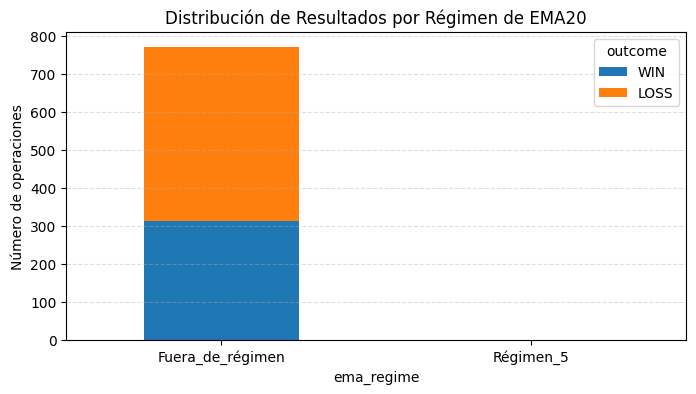

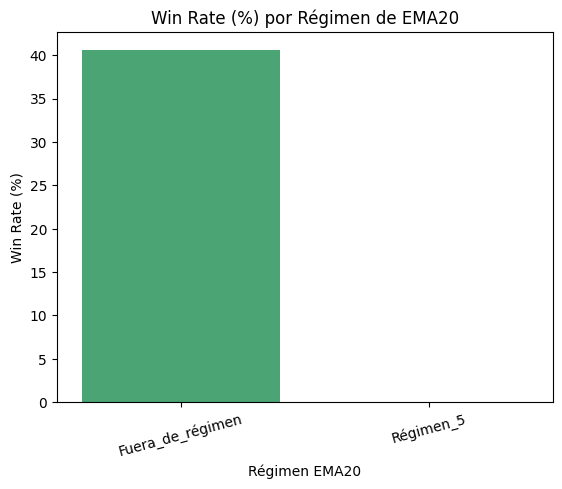

In [537]:
# Definir los rangos de regímenes dominantes (según tu histograma)
dominant_zones = [
    (1.08037, 1.08368),
    (1.08368, 1.08699),
    (1.08699, 1.09030),
    (1.09030, 1.09361),
    (1.13003, 1.13334)
]

# Clasificar cada operación en un régimen según su EMA20
def classify_ema_regime(value):
    for i, (low, high) in enumerate(dominant_zones, 1):
        if low <= value < high:
            return f"Régimen_{i}"
    return "Fuera_de_régimen"

df['ema_regime'] = df['ema20'].apply(classify_ema_regime)

# Calcular resultados por régimen
regime_stats = df.groupby(['ema_regime', 'outcome']).size().unstack(fill_value=0)
regime_stats['Total'] = regime_stats.sum(axis=1)
regime_stats['WinRate(%)'] = (regime_stats['WIN'] / regime_stats['Total'] * 100).round(2)

print("\n📊 Rendimiento por Régimen de EMA20:")
print(regime_stats)

# --- Gráficos ---
regime_stats[['WIN', 'LOSS']].plot(kind='bar', stacked=True, figsize=(8,4))
plt.title("Distribución de Resultados por Régimen de EMA20")
plt.ylabel("Número de operaciones")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()

sns.barplot(data=regime_stats.reset_index(), x='ema_regime', y='WinRate(%)', color='mediumseagreen')
plt.title("Win Rate (%) por Régimen de EMA20")
plt.ylabel("Win Rate (%)")
plt.xlabel("Régimen EMA20")
plt.xticks(rotation=15)
plt.show()

### 6. Análisis de correlación del MACD con los resultados de los setups

En esta sección se integran los valores del MACD (12, 26, 9) al dataset principal para evaluar si el momentum, medido por el cruce y la fuerza del histograma, muestra diferencias entre operaciones ganadoras y perdedoras.


In [455]:
import pandas as pd

# Cargar datasets

df_macd = pd.read_csv('../Data/EURUSD_H4_2019-2025_with_macd.csv')

# Asegurar formato de fecha

df_macd['datetime'] = pd.to_datetime(df_macd['datetime'])

# Unir por fecha de entrada del trade con el registro más cercano del MACD
df = pd.merge(setups, 
              df_macd[['datetime', 'macd', 'macd_signal', 'macd_histogram']],
              left_on='entry_date', right_on='datetime', 
              how='left')

# Verificar resultado
print(df[['entry_date', 'direction', 'outcome', 'macd', 'macd_signal', 'macd_histogram']].head())
print(f"\nTotal de filas combinadas: {len(df)}")


FileNotFoundError: [Errno 2] No such file or directory: '../Data/EURUSD_H4_2019-2025_with_macd.csv'

In [457]:
df.head()

,touch_date,entry_date,exit_date,direction,entry_price,sl_price,tp_price_ref,exit_price,sl_pips,tp_pips_estimated,result_pips,rr_ratio_estimated,rr_ratio_real,outcome,candles_away,candles_held,di_spread,datetime,open,high,low,close,volume,ema20,atr,atr_upper_2,atr_upper_entry,atr_upper_3,atr_lower_2,atr_lower_entry,atr_lower_3,adx,plus_di,minus_di,rsi,plus_di_minus_di,atr_level,adx_level,regimen,ema_regime
0,2020-03-04 12:00:00,2020-03-04 16:00:00,2020-03-04 18:00:00,LONG,1.10960,1.10810,1.11453,1.11431,15.0,49.3,47.1,3.29,3.14,WIN,4,2,9.51,2020-03-04 16:00:00,1.11248,1.11264,1.10948,1.11178,9585,1.114525,0.002143,1.118811,1.119454,1.120953,1.110240,1.109597,1.108098,26.392920,17.201274,26.711464,40.031846,9.510190,alto,medio,Intermedio,Fuera_de_régimen
1,2020-03-05 11:00:00,2020-03-05 14:00:00,2020-03-05 18:00:00,SHORT,1.11897,1.12018,1.11502,1.12018,12.0,39.6,-12.0,3.29,1.00,LOSS,3,4,16.96,2020-03-05 14:00:00,1.11827,1.11994,1.11788,1.11879,6094,1.115015,0.001721,1.118457,1.118973,1.120178,1.111573,1.111057,1.109853,17.529991,28.946965,11.994990,68.106984,16.951975,alto,bajo,Intermedio,Fuera_de_régimen
2,2020-03-12 11:00:00,2020-03-12 14:00:00,2020-03-12 15:00:00,LONG,1.12183,1.11995,1.12801,1.11995,18.8,61.8,-18.8,3.29,1.00,LOSS,3,1,14.96,2020-03-12 14:00:00,1.12330,1.12423,1.12110,1.12365,9653,1.128015,0.002689,1.133392,1.134199,1.136081,1.122637,1.121831,1.119949,18.835581,17.357578,32.324403,35.994046,14.966825,alto,bajo,Intermedio,Fuera_de_régimen
3,2020-03-12 15:00:00,2020-03-12 17:00:00,2020-03-12 17:00:00,LONG,1.11780,1.11534,1.12585,1.11534,24.5,80.6,-24.5,3.29,1.00,LOSS,2,0,13.65,2020-03-12 17:00:00,1.12385,1.12385,1.11310,1.11443,36431,1.125853,0.003503,1.132858,1.133909,1.136361,1.118847,1.117796,1.115344,17.304354,19.091549,32.740644,26.858329,13.649095,alto,bajo,Intermedio,Fuera_de_régimen
4,2020-03-13 15:00:00,2020-03-13 18:00:00,2020-03-16 00:00:00,LONG,1.10742,1.10479,1.11607,1.11384,26.3,86.5,64.3,3.29,2.44,WIN,3,6,18.41,2020-03-13 18:00:00,1.11073,1.11196,1.10658,1.10691,17545,1.116065,0.003760,1.123584,1.124712,1.127344,1.108546,1.107418,1.104786,23.194789,10.472519,28.878683,29.988827,18.406164,alto,medio,Intermedio,Fuera_de_régimen


In [459]:
from scipy import stats

# Estadísticas descriptivas por tipo de resultado
stats_macd = df.groupby('outcome')['macd_histogram'].agg(['mean', 'std', 'median', 'count'])
display(stats_macd)

# Prueba t de Student para comparar medias entre WIN y LOSS
win_values = df[df['outcome'] == 'WIN']['macd_histogram']
loss_values = df[df['outcome'] == 'LOSS']['macd_histogram']

t_stat, p_val = stats.ttest_ind(win_values, loss_values, equal_var=False)
print(f"T-statistic: {t_stat:.4f}, p-value: {p_val:.4f}")

# Interpretación rápida
if p_val < 0.05:
    print("➡️ Existe diferencia estadísticamente significativa entre WIN y LOSS.")
else:
    print("⚪ No se observa diferencia estadísticamente significativa entre WIN y LOSS.")

# Boxplot comparativo
plt.figure(figsize=(7,4))
sns.boxplot(x='outcome', y='macd_histogram', data=df, palette='coolwarm')
plt.title('Distribución del MACD Histogram por Resultado (WIN vs LOSS)')
plt.xlabel('Resultado del trade')
plt.ylabel('MACD Histogram en la entrada')
plt.grid(alpha=0.3)
plt.show()

KeyError: 'Column not found: macd_histogram'

El análisis muestra que el MACD Histogram no presenta diferencias significativas entre operaciones ganadoras y perdedoras (p = 0.86). Por tanto, el momentum no aporta valor predictivo en los puntos de entrada del sistema Mean Reversion H4.


In [462]:
### 9. Aplicación del filtro direccional |+DI − –DI| < 20

# Crear columna si no existe
if 'di_spread' not in df.columns:
    df['di_spread'] = abs(df['plus_di'] - df['minus_di'])

# Sin filtro
total_before = len(df)
winrate_before = (df['outcome'].eq('WIN').mean()) * 100

# Aplicar filtro
df_filtered = df[df['di_spread'] < 20]

# Métricas después del filtro
total_after = len(df_filtered)
winrate_after = (df_filtered['outcome'].eq('WIN').mean()) * 100

print(f"Total de setups antes del filtro: {total_before}")
print(f"Total después del filtro: {total_after}")
print(f"Win rate antes: {winrate_before:.2f}%")
print(f"Win rate después: {winrate_after:.2f}%")
print(f"Setups eliminados: {total_before - total_after} ({(1 - total_after/total_before)*100:.1f}%)")


Total de setups antes del filtro: 1070
Total después del filtro: 674
Win rate antes: 29.72%
Win rate después: 38.28%
Setups eliminados: 396 (37.0%)


In [464]:
### 9.1 Métricas comparativas antes y después del filtro direccional

def calcular_metricas(df_in):
    total = len(df_in)
    wins = df_in[df_in['outcome'] == 'WIN']
    losses = df_in[df_in['outcome'] == 'LOSS']
    
    win_rate = len(wins) / total * 100 if total > 0 else 0
    avg_win = wins['result_pips'].mean()
    avg_loss = losses['result_pips'].mean()
    expectancy = (win_rate/100) * avg_win + (1 - win_rate/100) * avg_loss
    profit_factor = abs(avg_win / avg_loss) if avg_loss != 0 else 0
    rr_est = df_in['rr_ratio_estimated'].mean()

    return {
        'Trades': total,
        'WinRate(%)': round(win_rate, 2),
        'AvgWin(pips)': round(avg_win, 2),
        'AvgLoss(pips)': round(avg_loss, 2),
        'Expectancy(pips)': round(expectancy, 2),
        'ProfitFactor': round(profit_factor, 2),
        'RR_est': round(rr_est, 2)
    }

# Calcular métricas antes y después
metrics_before = calcular_metricas(df)
metrics_after = calcular_metricas(df_filtered)

# Combinar en tabla
comparison = pd.DataFrame([metrics_before, metrics_after], index=['Antes filtro', 'Después filtro'])
display(comparison)


,Trades,WinRate(%),AvgWin(pips),AvgLoss(pips),Expectancy(pips),ProfitFactor,RR_est
Antes filtro,1070,29.72,27.50,-10.44,0.84,2.63,3.29
Después filtro,674,38.28,27.84,-10.44,4.21,2.67,3.29
